In [25]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [434]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,roc_curve,auc,roc_auc_score

In [3]:
"From kaggle competition evaluation metrix"
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d),g,d

In [107]:
final_data=pd.read_csv('Final_Data.csv')
req=final_data.columns
req=req[1:-1]
target=final_data['target']
data_x=final_data[req]
train_x,test_x,train_y,test_y=train_test_split(data_x,target,test_size=0.2)

In [108]:
lgm=lgb.LGBMClassifier(learning_rate=0.03, reg_lambda=50,
                          min_child_samples=2400,
                          num_leaves=94,
                          colsample_bytree=0.19,
                          max_bins=517, random_state=1,n_estimators=1150,
                            max_depth=5)
xgb=XGBClassifier(learning_rate =0.1,n_estimators=500,
max_depth=4,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective= 'binary:logistic',
nthread=4,
scale_pos_weight=1,
seed=2)


In [448]:
class model:
    def __init__(self):
        self.columns=[]
        self.lgb_list=[]
        self.xgb_list=[]
        for i in range(5):
            self.xgb_list.append(XGBClassifier(learning_rate =0.1,n_estimators=500,
                                max_depth=4,
                                min_child_weight=1,
                                gamma=0,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                objective= 'binary:logistic',
                                nthread=4,
                                scale_pos_weight=1,
                                seed=2))
        for i in range(5):
            self.lgb_list.append(lgb.LGBMClassifier(learning_rate=0.03, reg_lambda=50,
                          min_child_samples=2400,
                          num_leaves=94,
                          colsample_bytree=0.19,
                          max_bins=517, random_state=1,n_estimators=1200,
                            max_depth=6))
    def fit(self,tr_x,tr_y):
        cols=np.array(tr_x.columns)
        for model in self.lgb_list:
            ttr_x,tes,ttr_y,t2=train_test_split(tr_x,tr_y,test_size=0.3,shuffle=True)
            model.fit(ttr_x,ttr_y)
        for model in self.xgb_list:
            ttr_x,tes,ttr_y,t2=train_test_split(tr_x,tr_y,test_size=0.3,shuffle=True)
            model.fit(ttr_x,ttr_y)
    def predict(self,test):
        pred=np.zeros(test.shape[0])
        ind=0
        for model in self.lgb_list:
            pred+=model.predict(test)
        for model in self.xgb_list:
            pred+=model.predict(test)
        pred=pred/10
        for i in range(len(pred)):
            if(pred[i]>=0.5):
                pred[i]=1
            else:
                pred[i]=0
        return pred
    def predict_proba(self,test):
        pred=np.zeros((test.shape[0],2))
        for model in self.lgb_list:
            pred+=model.predict_proba(test)
        for model in self.xgb_list:
            pred+=model.predict_proba(test)
        return pred/10

In [449]:
mo=model()
mo.fit(train_x,train_y)

In [450]:
import matplotlib.pyplot as plt

The Accuracy Score is 0.8800992680236639
The Precision is 0.737330910559257
The recall is 0.7389720760825577
The f1 score is 0.7381505811015665
The area under curve 0.9322236315021242


Text(0.5, 1.0, 'ROC Curve')

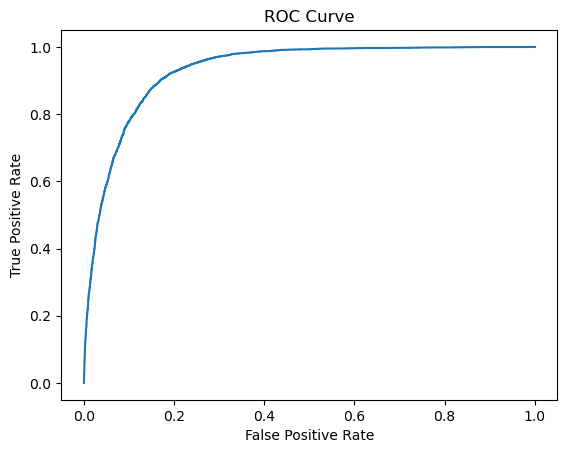

In [454]:
pred=mo.predict(test_x)
print("The Accuracy Score is {}".format(accuracy_score(pred,test_y)))
pre_recall_f1=precision_recall_fscore_support(test_y,pred,average='binary')
print("The Precision is {}".format(pre_recall_f1[0]))
print("The recall is {}".format(pre_recall_f1[1]))
print("The f1 score is {}".format(pre_recall_f1[2]))
pred_proba_y=mo.predict_proba(test_x)
fpr, tpr, thresholds_roc = roc_curve(test_y,pred_proba_y[:,1])
roc_auc = auc(fpr,tpr)
print("The area under curve {}".format(roc_auc))
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(test_y,best_param.predict(test_x))
m=plot_confusion_matrix(best_param,test_x,test_y, cmap=plt.cm.Blues)
plt.show()

In [455]:
test_y_num=np.array(train_y)
df=pd.DataFrame(test_y_num,columns=['target'])
df2=pd.DataFrame(mo.predict_proba(train_x)[:,1],columns=['prediction'])

In [456]:
gd,g,d=amex_metric(df,df2)
print("Gini coefficient {}".format(g))
print("Top 4% capture {}".format(d))
print("Final eval metric {}".format(gd))

Gini coefficient 0.8917960681457701
Top 4% capture 0.553459440167236
Final eval metric 0.722627754156503


In [457]:
final_data=pd.read_csv('Final_Data_new.csv')
req=final_data.columns
req=req[2:-1]
target=final_data['target']
data_x=final_data[req]
train_x,test_x,train_y,test_y=train_test_split(data_x,target,test_size=0.2)

In [458]:
mo=model()
mo.fit(train_x,train_y)

The Accuracy Score is 0.8931385741502056
The Precision is 0.7264529058116233
The recall is 0.7352941176470589
The f1 score is 0.7308467741935484
The area under curve 0.9280193216485244


Text(0.5, 1.0, 'ROC Curve')

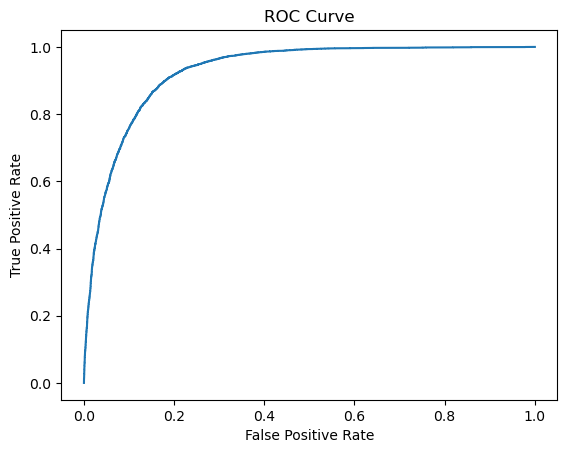

In [463]:
pred=mo.predict(test_x)
print("The Accuracy Score is {}".format(accuracy_score(pred,test_y)))
pre_recall_f1=precision_recall_fscore_support(test_y,pred,average='binary')
print("The Precision is {}".format(pre_recall_f1[0]))
print("The recall is {}".format(pre_recall_f1[1]))
print("The f1 score is {}".format(pre_recall_f1[2]))
pred_proba_y=mo.predict_proba(test_x)
fpr, tpr, thresholds_roc = roc_curve(test_y,pred_proba_y[:,1])
roc_auc = auc(fpr,tpr)
print("The area under curve {}".format(roc_auc))
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [464]:
test_y_num=np.array(train_y)
df=pd.DataFrame(test_y_num,columns=['target'])
df2=pd.DataFrame(mo.predict_proba(train_x)[:,1],columns=['prediction'])

In [465]:
gd,g,d=amex_metric(df,df2)
print("Gini coefficient {}".format(g))
print("Top 4% capture {}".format(d))
print("Final eval metric {}".format(gd))

Gini coefficient 0.8930167637014855
Top 4% capture 0.5674904458598726
Final eval metric 0.7302536047806791
